[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kamerlinlab/KIF/blob/main/tutorials/Workup_PDZ_Bootstrapping.ipynb)

## Bootstrapping Analysis on Simulations of PDZ Domain

In this notebook we will workup bootstrapping calculations performed on the PDZ domain. This analysis is the same as the we performed in our [preprint](https://chemrxiv.org/engage/chemrxiv/article-details/63afa03c963bf350c9abb601), so please feel free to check out the discussion about those results there too. 

Bootstrapping with replacement is a technique that allows you to calculate summary statistics. [You can read more about the method here](https://machinelearningmastery.com/a-gentle-introduction-to-the-bootstrap-method/#:~:text=The%20bootstrap%20method%20is%20a,the%20mean%20or%20standard%20deviation.). 

In our manuscript, we used bootstrapping to investigate how: 
1. Using a reduced number of replicas would impact the reproducibility of our results. 
2. Using a large timestep between frames would impact the reproducibility of our results.

You can read our [preprint](https://chemrxiv.org/engage/chemrxiv/article-details/63afa03c963bf350c9abb601) for more details and interpretation of our results. 

Performing the bootstrapping itself is quite computationally intensive (as you do 5000 repeats for each scenario) so it is not included here. If you would like to perform bootstrapping yourself on your own KIF results, our [ZENODO](https://zenodo.org/record/7104965#.Y5ht1HbMJPY) submission has an example for you. 

### Setup

Install and load the required modules and then download the dataset we'll be working on from google drive

In [1]:
# Alongside installing KIF, we'll be using plotly to visualise some of the results. 
# We'll use kaleido with plotly.
%pip install KIF plotly 
%pip install -U kaleido 

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from typing import Tuple
import pandas as pd
import numpy as np
import scipy.stats 
import plotly.express as px
from key_interactions_finder import pycontact_processing
from key_interactions_finder import data_preperation
from key_interactions_finder import stat_modelling
from key_interactions_finder import post_proccessing

from sklearn.neighbors import KernelDensity

We will first need to donwload the PTP1B dataset from google drive. 
The tutorial data will be saved in the relative path defined by "save_dir" in the cell block below.

You can change this as you see fit. If you want to use the current directory you can do:

save_dir=""

In [3]:
from key_interactions_finder.utils import download_prep_tutorial_dataset

drive_url = r"https://drive.google.com/file/d/1G4n-CXoqtt_qZtDfDXbByJtMTpbeIA4l/view?usp=share_link"
save_dir = "tutorial_datasets"

download_prep_tutorial_dataset(drive_url=drive_url, save_dir=save_dir)

Downloading...
From: https://drive.google.com/uc?id=1G4n-CXoqtt_qZtDfDXbByJtMTpbeIA4l
To: c:\Users\Rory Crean\Desktop\Github\key-interactions-finder\tutorials\tutorial_datasets\tutorial_dataset.zip
100%|██████████| 26.6M/26.6M [00:00<00:00, 27.1MB/s]


Tutorial files were successfully downloaded and unzipped.


At this point, we'll define the location of our downloaded input files and where we would like to save our output files to throughout this tutorial.

In [4]:
# Contains the "ground truth" for these experiments
js_per_res_scores_file = save_dir + r"/PDZ_Bootstrap/PDZ_Numb_Replicas/Jensen_Shannon_Distance_Scores_Per_Residue.csv"

# For evaluating how the number of replicas chosen impacts the results (Part 1 Below)
in_dir_replicas = save_dir + r"/PDZ_Bootstrap/PDZ_Numb_Replicas/Bootstrap_results"

# For evaluating how the spacing between replica frames chosen impacts the results (Part 2 Below)
in_dir_traj_gap = save_dir + r"/PDZ_Bootstrap/PDZ_Traj_Gap/Bootstrap_results"


### Part 1 - Bootstrapping on Number of Replicas:
Combinations of bound and unbound conformation simulation replicas were bootstrapped 5000 times each 

- 1 random replica from bound with 1 random replica from unbound
- 2 random replicas from bound with 2 random replicas from unbound
- ..............
- 10 random replicas from bound with 10 random replicas from unbound

### Load in bootstrapping results and post-process

- Each replicas results are stored as the values in the dictionary as a 1D numpy array.
- The data structure for each array is that the first 5000 items are for the top residue, the 2nd 5000 for the 2nd top residue, and so on.
- The top 100 residues (determined according to the result with all replicas used) are included in the array.
- The value stored is the difference between the result obtained from all 20 seperate replicas combined. 

In [5]:
bootstrap_results_replicas = {}
for i in range(1, 11, 1):
    file_in = in_dir_replicas + "/PDZ_Bootstrap_" + str(i) + "Replicas_5000Samples.csv"
    key_name = "Replicas" + str(i)
    results = np.loadtxt(file_in)
    bootstrap_results_replicas.update({key_name: results})

bootstrap_results_replicas.keys()

dict_keys(['Replicas1', 'Replicas2', 'Replicas3', 'Replicas4', 'Replicas5', 'Replicas6', 'Replicas7', 'Replicas8', 'Replicas9', 'Replicas10'])

As we can see the results from each run are stored in a single dictionary and we can take a look at one run in the next block to see it is a 1D array of length 500000 (5000 repeats X 100 residue scores per repeat)

In [6]:
display(len(bootstrap_results_replicas["Replicas10"]))

bootstrap_results_replicas["Replicas10"]

500000

array([ 0.     ,  0.     ,  0.     , ..., -0.03609, -0.02364, -0.05232])

### Obtain Spearmans rank and Pearson correlation for each bootstrap run...

Now we will calculate the correlation between each bootstrap samples per residue scores against the one obtained from using all 20 individual replicas (which we are treating as "the ground truth")

This is only for the top 100 residues (tests were performed, see below to see if the results were sensitive to the number of residues selected, and they were not). 

In [7]:
df_ground_truths= pd.read_csv(js_per_res_scores_file)
js_per_res_scores = np.asarray(df_ground_truths["Normalised Score"][0:100])
len(js_per_res_scores)

100

In [8]:
# The scores for each residue to compare against.
js_per_res_scores

array([1.     , 0.73718, 0.73597, 0.53632, 0.48098, 0.39685, 0.39492,
       0.36659, 0.32915, 0.3276 , 0.31696, 0.31371, 0.31047, 0.30514,
       0.30471, 0.29962, 0.29903, 0.2941 , 0.29006, 0.28143, 0.28134,
       0.27723, 0.27505, 0.27449, 0.26343, 0.26319, 0.26306, 0.25478,
       0.23035, 0.2178 , 0.21573, 0.21037, 0.20298, 0.20276, 0.19607,
       0.19163, 0.19067, 0.18792, 0.184  , 0.17981, 0.177  , 0.16978,
       0.16667, 0.16114, 0.15723, 0.15687, 0.15335, 0.15284, 0.15235,
       0.14818, 0.14647, 0.14329, 0.14265, 0.1385 , 0.13736, 0.13689,
       0.13603, 0.13502, 0.12399, 0.12391, 0.12293, 0.12217, 0.12115,
       0.11362, 0.1113 , 0.10669, 0.10662, 0.10219, 0.1006 , 0.10013,
       0.09817, 0.09719, 0.09693, 0.09589, 0.09353, 0.09324, 0.09319,
       0.09258, 0.09211, 0.09207, 0.09023, 0.08628, 0.08521, 0.0845 ,
       0.08437, 0.08399, 0.08188, 0.07905, 0.07428, 0.07376, 0.07263,
       0.06315, 0.06273, 0.061  , 0.0574 , 0.05631, 0.05551, 0.05453,
       0.04967, 0.04

In the cell below, the function calc_correl() will allow us to calculate our correlation scores for each bootstrapp sample.

We will measure correlation with two methods:

1. Pearson correlation coefficient - classic linear correlation calculation.
2. Spearman rank-order correlation coefficient - Measures how good the rank ordering of the per residue scores are.

In [9]:
def calc_correl_replicas(js_per_res_scores:np.array, bootstrap_results:dict) -> Tuple[dict, dict]:
    """ 
    Calculate the Spearmans rank and pearsons R correl coeffs for 
    each bootstrap result against the ground truth.

    Parameters
    ----------
    js_per_res_scores : np.array
        The per residue scores being treated as "the ground truth" to measure the 
        correlation against. 
    
    bootstrap_results : dict
        Keys are number of replicas used (as strings),
        Values are the per residue scores for each bootstrap sample stored
        as a 1D np.array. 

    Returns
    ----------
    all_pearson : dict
        Keys are number of replicas used (as strings)
        values are the pearson correlation coeff for each bootstrap sample. 

    all_spearman : dict
        Keys are number of replicas used (as strings)
        values are the pearson correlation coeff for each bootstrap sample. 
    """
    # This goes through every bootstrap run one at a time. 
    all_pearson, all_spearman = {}, {}
    for i in range(1, 11, 1):
        replica = "Replicas" + str(i)

        pearson_r_scores, spearman_scores = [], []
        for bootstrap_idx in range(0, 5000, 1): # 5000 runs... 
            # every 5000 frames is the beginning of a new residue.
            # Therefore bootstrap run 1 values = 0, 5000, 10,000 etc... 
            bootstrap_diffs = bootstrap_results[replica][bootstrap_idx::5000] 
            # The value saved to disk was the difference between them, so convert back for calc. 
            bootstrap_scores = js_per_res_scores + bootstrap_diffs

            pearson = scipy.stats.pearsonr(js_per_res_scores, bootstrap_scores)
            spearman = scipy.stats.spearmanr(js_per_res_scores, bootstrap_scores)

            pearson_r_scores.append(pearson[0])
            spearman_scores.append(spearman[0])
        
        all_pearson.update({replica: pearson_r_scores})
        all_spearman.update({replica: spearman_scores})

    return all_pearson, all_spearman

In [10]:
all_pearson_replicas, all_spearman_replicas = calc_correl_replicas(
    js_per_res_scores=js_per_res_scores, 
    bootstrap_results=bootstrap_results_replicas
)

display(all_pearson_replicas.keys())
len(all_pearson_replicas["Replicas10"])

dict_keys(['Replicas1', 'Replicas2', 'Replicas3', 'Replicas4', 'Replicas5', 'Replicas6', 'Replicas7', 'Replicas8', 'Replicas9', 'Replicas10'])

5000

We can see that the results obtained are now stored as a dictionary and each replica contains 5000 values which correspond to the correlation score for each bootstrap sample. With this, we can now generate kernel density estimates to visualise the distribtuions obtained for a given number of replicas.

In [11]:
def calc_kdes_replicas(correl_scores: dict, kde_bandwidth: float = 0.02) -> pd.DataFrame:
    """ 
    Calc kernel density estimates for the pearson correlation and spearman ranks scored obtained from bootstrapping.
    
    Takes a dict of numb of replicas (keys) and correlation scores (respective values).
    Outputs a dataframe with new column for diff numb of replicas. 

    Parameters
    ----------
    correl_scores : dict
        The per residue scores being treated as "the ground truth" to measure the 
        correlation against. 
    
    kde_bandwidth : float
        Bandwidth used to generate the probabilty distribtions for each feature set.
        Note that features are all scaled to be between 0 and 1 before this step.
        Default = 0.02

    Returns
    ----------
    pd.DataFrame
        df of kernel density estimates, each column is for a new replica. 
    """
    all_kdes = {}
    kde_bandwidth = 0.02
    x_values = np.asarray([value for value in np.arange(0.0, 1.02, kde_bandwidth)])
    x_values = x_values.reshape((int(1.02/kde_bandwidth)), 1)
    x_values_unpacked = [value[0] for value in list(x_values)]
    all_kdes.update({"x_values": x_values_unpacked})

    for i in range(1, 11, 1):
        replica = "Replicas" + str(i)
        
        model = KernelDensity(bandwidth=kde_bandwidth, kernel="gaussian")
        feature_values = (np.asarray(correl_scores[replica])).reshape(-1, 1)
        model.fit(feature_values)
        probablities = np.exp(model.score_samples(x_values))
        all_kdes.update({replica : probablities})

    return pd.DataFrame.from_dict(all_kdes) 

In [12]:
# run the above function and store the output.
kdes_spearman_replicas = calc_kdes_replicas(correl_scores=all_spearman_replicas)
kdes_pearson_replicas = calc_kdes_replicas(correl_scores=all_pearson_replicas)

display(len(kdes_spearman_replicas))
display(kdes_spearman_replicas.head(3))
display(kdes_spearman_replicas.tail(3))

51

,x_values,Replicas1,Replicas2,Replicas3,Replicas4,Replicas5,Replicas6,Replicas7,Replicas8,Replicas9,Replicas10
0,0.00,9.282209e-29,1.785040e-30,2.240426e-39,6.747732e-35,2.382731e-36,1.046180e-61,7.099481e-55,4.753672e-57,1.297141e-56,7.312027e-61
1,0.02,4.211547e-24,8.099129e-26,5.552731e-34,7.332576e-30,3.403132e-31,8.661146e-55,2.180199e-48,2.036573e-50,5.151405e-50,5.352414e-54
2,0.04,7.029711e-20,1.351868e-21,5.062895e-29,2.931305e-25,1.788084e-26,2.641494e-48,2.463038e-42,3.215838e-44,7.526101e-44,1.441392e-47


,x_values,Replicas1,Replicas2,Replicas3,Replicas4,Replicas5,Replicas6,Replicas7,Replicas8,Replicas9,Replicas10
48,0.96,0.228854,0.335398,0.558552,0.687326,1.067459,1.245040,1.608635,2.056112,2.459680,3.102327
49,0.98,0.040922,0.088059,0.148640,0.195531,0.323577,0.381729,0.532268,0.705404,0.896198,1.242462
50,1.00,0.002810,0.013049,0.022348,0.030463,0.050735,0.063727,0.095775,0.131929,0.177443,0.265862


In [13]:
# Uncomment below if you want to save these results to disk. 

# out_folder = "bootstrap_kdes" # TODO update... 

# out_file = out_folder + "/DZ_kdes_spearman_replicas.csv"
# kdes_spearman_replicas.to_csv(out_file, index=False)

# out_file = out_folder + "/PDZ_kdes_pearson_replicas.csv"
# kdes_pearson_replicas.to_csv(out_file, index=False)

Now we have produced the kernel density estimates and (optionally) saved them, we can take a quick look at the results with plotly to see what they look like.

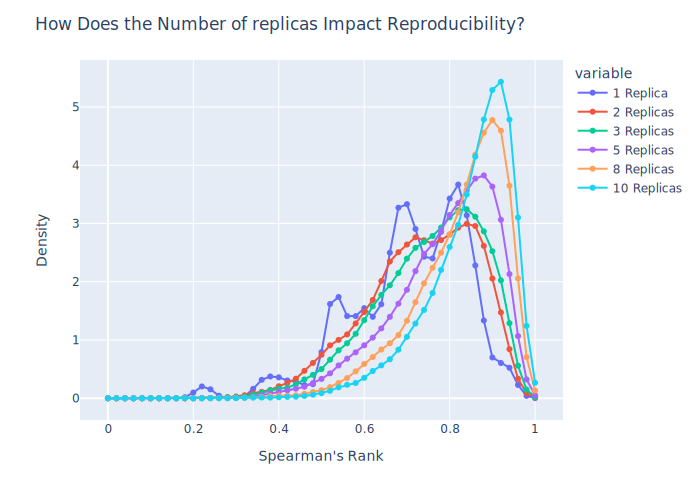

In [14]:
y_axes = ["Replicas1", "Replicas2", "Replicas3", "Replicas5", "Replicas8", "Replicas10"]

new_trace_names = {
    "Replicas1" : "1 Replica", 
    "Replicas2" : "2 Replicas",
    "Replicas3" : "3 Replicas",
    "Replicas5" : "5 Replicas",
    "Replicas8" : "8 Replicas",
    "Replicas10" : "10 Replicas",
}

fig = px.line(kdes_spearman_replicas, x="x_values", y=y_axes, markers=True)
fig.update_layout(title="How Does the Number of replicas Impact Reproducibility?",
                   xaxis_title="Spearman's Rank",
                   yaxis_title='Density')

fig.for_each_trace(lambda t: t.update(name = new_trace_names[t.name],
                                      legendgroup = new_trace_names[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, new_trace_names[t.name])
                                     )
                  )
fig.show("svg")

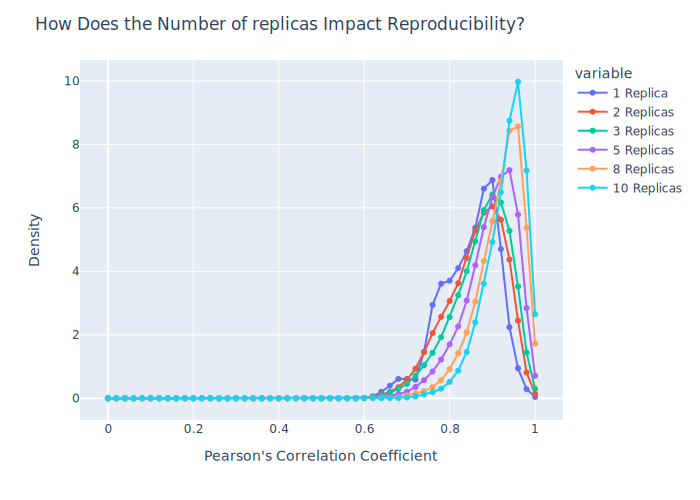

In [15]:
# Likewise we can check the results out for our other correlation metric. 
fig = px.line(kdes_pearson_replicas, x="x_values", y=y_axes, markers=True)
fig.update_layout(title="How Does the Number of replicas Impact Reproducibility?",
                   xaxis_title="Pearson's Correlation Coefficient",
                   yaxis_title='Density')

fig.for_each_trace(lambda t: t.update(name = new_trace_names[t.name],
                                      legendgroup = new_trace_names[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, new_trace_names[t.name])
                                     )
                  )
fig.show("svg")

Clearly we see just 1 replica (from each state, so effectively 2 simulations) is not enough to obtain reliable results. In the paper we argued 5 was reasonable to be confident, but there is no hard and fast rule that says what is enough. 

In part 2, we will work with 5 replicas and investigate how much the time spacing between frames impact the reprodubcibility of our results.

## Part 2: Bootstrapping on the spacing between replica frames. 

Now we will workup the bootstrapping results obtained from Part1 

using 5 replicas from both conformational states based on Part 1. 
This time 

In [16]:
# 0_1 = 0.1 ns time step etc... 
scenarios = ["0_1ns", "0_2ns", "0_3ns", "0_6ns", "0_8ns", "1ns", "2ns", "5ns", "10ns"]

bootstrap_results_traj_gap = {}
for scenario in scenarios:
    file_in = in_dir_traj_gap + "/PDZ_Bootstrap_" + scenario + "Gap_5Replicas_5000Samples.csv"
    results = np.loadtxt(file_in)
    bootstrap_results_traj_gap.update({scenario: results})

bootstrap_results_traj_gap.keys()

dict_keys(['0_1ns', '0_2ns', '0_3ns', '0_6ns', '0_8ns', '1ns', '2ns', '5ns', '10ns'])

In [17]:
display(len(bootstrap_results_traj_gap["0_1ns"]))
bootstrap_results_traj_gap["0_1ns"]

500000

array([ 0.     ,  0.     ,  0.     , ..., -0.04554, -0.08571, -0.03878])

As you can see, the data is organised in essentially the exact same way as was done in Part 1.

In [18]:
# The "ground truth" we shall compare to was already generated in step 1. 
len(js_per_res_scores)

100

just like in part 1, we will now determine the values of our two correlation coeffcients for each bootstrap sample. Note that whilst the function below is similar to the equivalent calc_correl_replicas in Part 1, it is not identical!

In [19]:
def calc_correl_traj_gap(js_per_res_scores:np.array, bootstrap_results:dict) -> Tuple[dict, dict]:
    """ 
    Calculate the Spearmans rank and pearsons R correl coeffs for 
    each bootstrap result against the ground truth.

    Parameters
    ----------
    js_per_res_scores : np.array
        The per residue scores being treated as "the ground truth" to measure the 
        correlation against. 
    
    bootstrap_results : dict
        Keys are the time steps used (as strings)
        Values are the per residue scores for each bootstrap sample stored
        as a 1D np.array. 

    Returns
    ----------
    all_pearson : dict
        Keys are the time steps used (as strings)
        values are the pearson correlation coeff for each bootstrap sample. 

    all_spearman : dict
        Keys are the time steps used (as strings)
        values are the pearson correlation coeff for each bootstrap sample. 
    """
    # This goes through every bootstrap run one at a time. 
    all_pearson, all_spearman = {}, {}
    for scenario in scenarios:

        pearson_r_scores, spearman_scores = [], []
        for bootstrap_idx in range(0, 5000, 1): # 5000 runs... 
            # every 5000 frames, beginning of new residue.
            # Therefore run 1: 0, 5000, 10,000 etc... 
            bootstrap_diffs = bootstrap_results[scenario][bootstrap_idx::5000] 
            bootstrap_scores = js_per_res_scores + bootstrap_diffs

            pearson = scipy.stats.pearsonr(js_per_res_scores, bootstrap_scores)
            spearman = scipy.stats.spearmanr(js_per_res_scores, bootstrap_scores)

            pearson_r_scores.append(pearson[0])
            spearman_scores.append(spearman[0])
        
        all_pearson.update({scenario: pearson_r_scores})
        all_spearman.update({scenario: spearman_scores})

    return all_pearson, all_spearman

In [20]:
all_pearson_traj_gap, all_spearman_traj_gap = calc_correl_traj_gap(
    js_per_res_scores=js_per_res_scores, 
    bootstrap_results=bootstrap_results_traj_gap
)

In [21]:
def calc_kdes_traj_gap(correl_scores: dict, kde_bandwidth: float = 0.02) -> pd.DataFrame:
    """ 
    Calc kernel density estimates for the pearson correlation and spearman ranks scored obtained from bootstrapping.
    
    Takes a dict of diff scenarios (keys) and correlation scores (respective values).
    Outputs a dataframe with new column for each diff scenario. 

    Parameters
    ----------
    correl_scores : dict
        The per residue scores being treated as "the ground truth" to measure the 
        correlation against. 
    
    kde_bandwidth : float
        Bandwidth used to generate the probabilty distribtions for each feature set.
        Note that features are all scaled to be between 0 and 1 before this step.
        Default = 0.02

    Returns
    ----------
    pd.DataFrame
        df of kernel density estimates, each column is for a new replica. 
    """
    all_kdes = {}
    kde_bandwidth = 0.02
    x_values = np.asarray([value for value in np.arange(0.0, 1.02, kde_bandwidth)])
    x_values = x_values.reshape((int(1.02/kde_bandwidth)), 1)
    x_values_unpacked = [value[0] for value in list(x_values)]
    all_kdes.update({"x_values": x_values_unpacked})

    for scenario in scenarios:
        model = KernelDensity(bandwidth=kde_bandwidth, kernel="gaussian")
        feature_values = (np.asarray(correl_scores[scenario])).reshape(-1, 1)
        model.fit(feature_values)
        probablities = np.exp(model.score_samples(x_values))
        all_kdes.update({scenario: probablities})

    return pd.DataFrame.from_dict(all_kdes) 

In [22]:
kdes_spearman_traj_gap = calc_kdes_traj_gap(correl_scores=all_spearman_traj_gap)
kdes_pearson_traj_gap = calc_kdes_traj_gap(correl_scores=all_pearson_traj_gap)

In [23]:
# # uncomment this cell block if you would like to save the results. 

# out_folder = "" # add one if you want. 
# out_file = out_folder + "/PDZ_kdes_spearman_traj_gap.csv"
# kdes_spearman_traj_gap.to_csv(out_file, index=False)

# out_file = out_folder + "/PDZ_kdes_pearson_traj_gap.csv"
# kdes_pearson_traj_gap.to_csv(out_file, index=False)

Now we have produced the kernel density estimates and (optionally) saved them, we can take a quick look at the results with plotly to see what they look like.

In [24]:
### scenarios = ["0_1ns", "0_2ns", "0_3ns", "0_6ns", "0_8ns", "1ns", "2ns", "5ns", "10ns"]
kdes_spearman_traj_gap.columns

Index(['x_values', '0_1ns', '0_2ns', '0_3ns', '0_6ns', '0_8ns', '1ns', '2ns',
       '5ns', '10ns'],
      dtype='object')

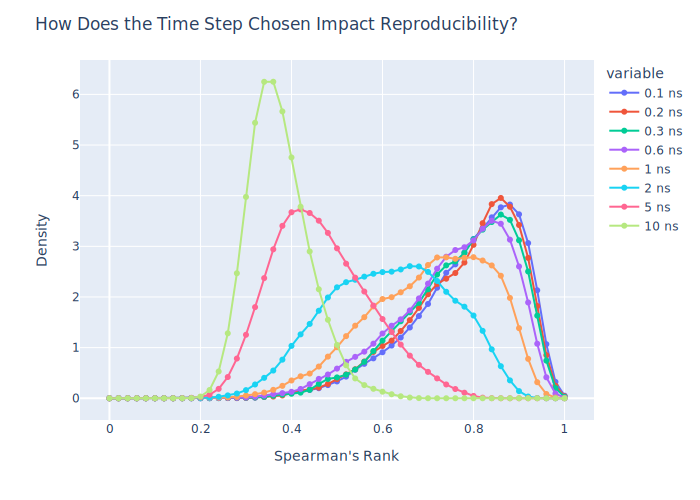

In [25]:
y_axes = ["0_1ns", "0_2ns", "0_3ns", "0_6ns", "1ns", "2ns", "5ns", "10ns"]

new_trace_names = {
    "0_1ns" : "0.1 ns", 
    "0_2ns" : "0.2 ns",
    "0_3ns" : "0.3 ns",
    "0_6ns" : "0.6 ns",
    "1ns" : "1 ns",
    "2ns" : "2 ns",
    "5ns" : "5 ns",
    "10ns" : "10 ns",
}

fig = px.line(kdes_spearman_traj_gap, x="x_values", y=y_axes, markers=True)
fig.update_layout(title="How Does the Time Step Chosen Impact Reproducibility?",
                   xaxis_title="Spearman's Rank",
                   yaxis_title='Density')

fig.for_each_trace(lambda t: t.update(name = new_trace_names[t.name],
                                      legendgroup = new_trace_names[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, new_trace_names[t.name])
                                     )
                  )
fig.show("svg")

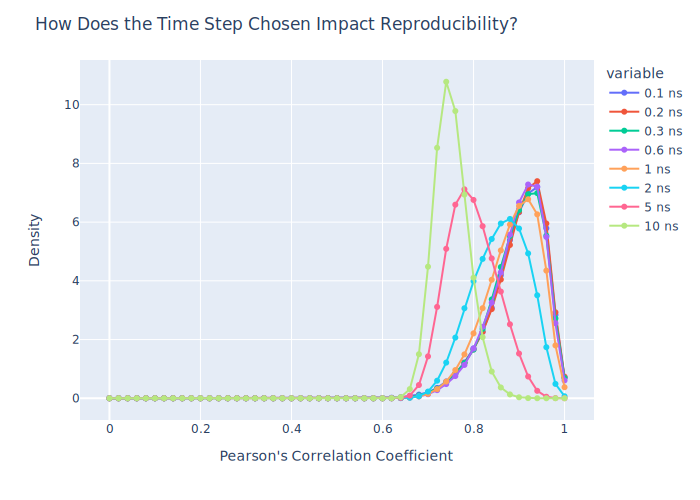

In [26]:
# Likewise we can check the results out for our other correlation metric. 
fig = px.line(kdes_pearson_traj_gap, x="x_values", y=y_axes, markers=True)
fig.update_layout(title="How Does the Time Step Chosen Impact Reproducibility?",
                   xaxis_title="Pearson's Correlation Coefficient",
                   yaxis_title='Density')

fig.for_each_trace(lambda t: t.update(name = new_trace_names[t.name],
                                      legendgroup = new_trace_names[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, new_trace_names[t.name])
                                     )
                  )
fig.show("svg")

And there we have it. Both correlation metrics seem to show we could get away with using a reduced sampling frequency (maybe 0.6 ns for example instead of 0.1 ns). That's 6 times less frames to store and then analyse with PyContact and KIF. 

Remember though, these results are system dependant, so it can be guaranteed that this selection would be appropriate for your system(s). 